In [266]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stoats-radius-20/all.csv
/kaggle/input/stoats-no-traps-radius-10/all.csv
/kaggle/input/stoats-steps-to-food-death/stepstofooddeath.csv
/kaggle/input/fooddeath/fooddeath full example/fooddeath_example_r10_15stoats_0.25density_15traps.csv
/kaggle/input/fooddeath/fooddeath full example/fooddeath_example_r10_15stoats_0.25density_notraps.csv
/kaggle/input/stoats-populations-no-traps-stoatdeath/stoatdeath_singleexample_density025_15stoats_r10_notraps.csv
/kaggle/input/stoats-no-traps-r-20/all.csv
/kaggle/input/stoats-traps-population-equal-traps/stoatdeath_singleexample_density025_15stoats_r10_15traps.csv
/kaggle/input/stoats-radius-10/all.csv


# 1. Introduction

Invasive stoat populations in New Zealand have been a key factor for the decline of endemic species on the islands since their introduction in the late 19th century. Endemic bird populations have observed the steepest decline with many ground-nesting birds oblivious to this newly introduced predator. The aims of our project are to (1) model the spread and growth of invasive stoat populations on an isolated island in New Zealand, (2) model and determine the optimal number of stoat traps, and (3) expand our model to account for key endemic bird and other prey populations. The combined findings of aims 1-3 will allow us to predict the future status of New Zealand stoat populations and their effects on certain endemic prey populations. 
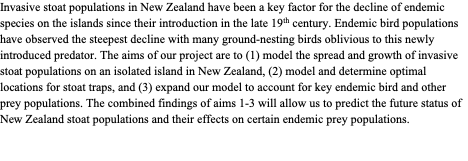
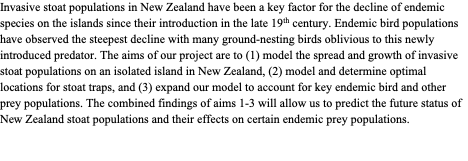
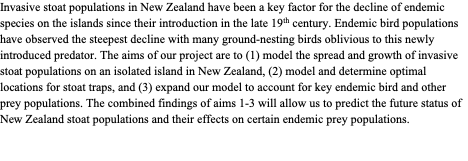
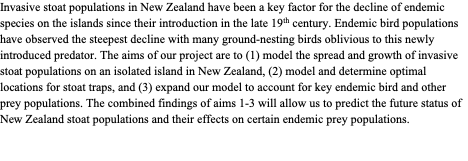

# 2. Background

Invasive stoat populations in New Zealand have been a key factor for the decline of endemic species on the islands since their introduction in the late 19th century. They were originally introduced to control rabbit populations that were destroying sheep pasture. Endemic bird populations have observed the steepest decline with many ground-nesting birds oblivious to this newly introduced predator. Stoats can live in any habitat where they can find prey, swim across kilometer long gaps to reach islands, and are avid climbers. This versatility has allowed the species to proliferate many of the islands in New Zealand, with stoats being detected on at least 90 islands. The primary aim of this project is to model the spread and growth of invasive stoat populations on an isolated island in New Zealand. Additional aims include the modeling and determination of optimal numbers of stoat traps as well as an expansion of the model to include key prey populations. Ideally, such a model will allow us to predict population sizes and distributions for use in conservation management..

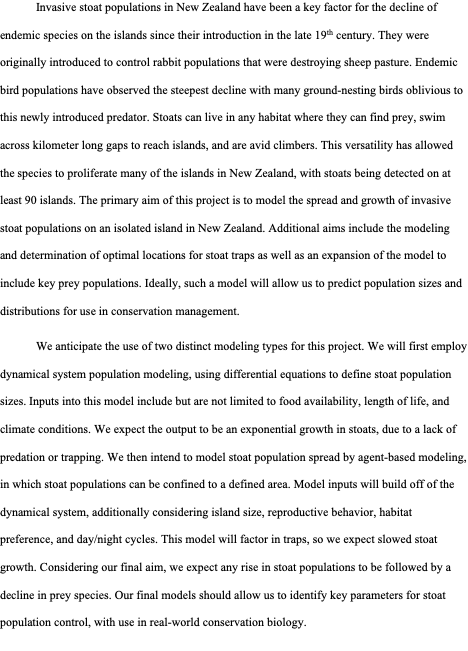
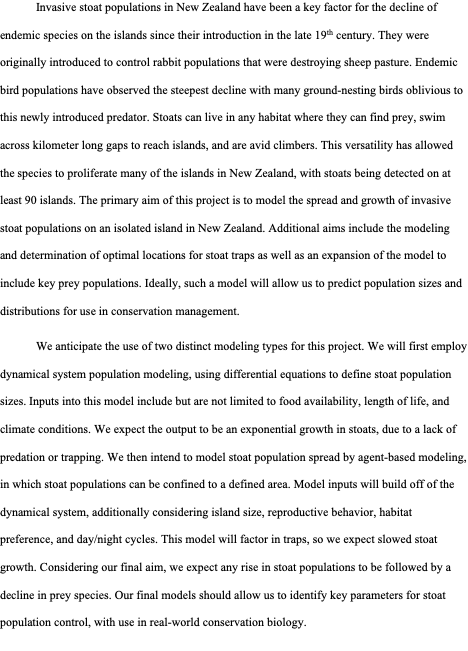
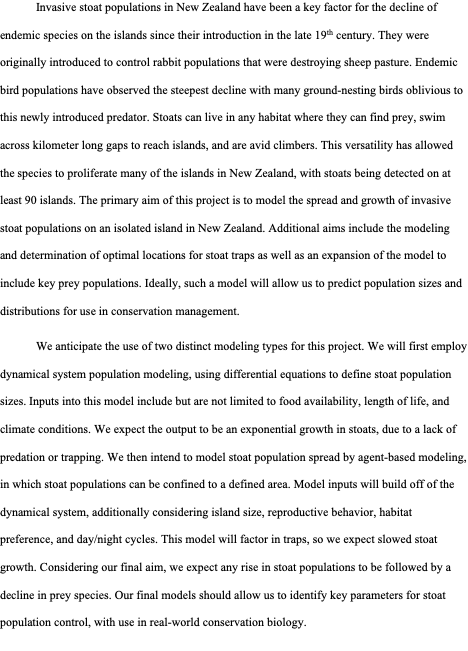
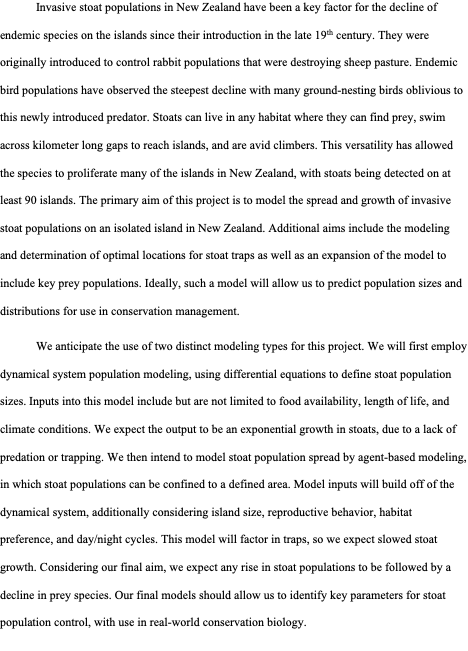

We anticipate the use of two distinct modeling types for this project. We will first employ dynamical system population modeling, using differential equations to define stoat population sizes. Inputs into this model include but are not limited to food availability, length of life, and climate conditions. We expect the output to be an exponential growth in stoats, due to a lack of predation or trapping. We then intend to model stoat population spread by agent-based modeling, in which stoat populations can be confined to a defined area. Model inputs will build off of the dynamical system, additionally considering island size and reproductive behavior. This model will factor in traps, so we expect slowed stoat growth. Considering our final aim, we expect any rise in stoat populations to be followed by a decline in prey species. Our final models should allow us to identify key parameters for stoat population control, with use in real-world conservation biology.

# 3. Model Descriptions

Establishing the parameters that determine stoat distributions across isolated islands allows researchers to evaluate the causes and effects of stoat invasions. Here we analyze stoat population size via dynamical systems modeling and describe invasion behaviors with agent-based modeling.

**3.1 Dynamical Systems**

To model the growth of stoat populations and subsequent prey populations, we are using dynamical system modeling. We initially used the Lotka–Volterra model using parameters such as predator and prey density, growth rate, and death rate, where x is the density of prey, a is the prey growth rate, and b is the prey death rate. In the stoat differential equation, y is stoat density, d is growth rate, and o is death rate. 
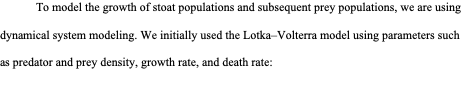
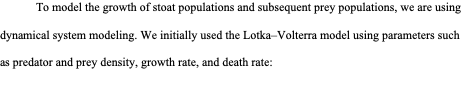
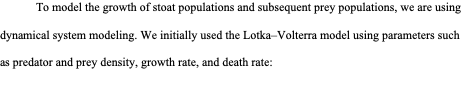
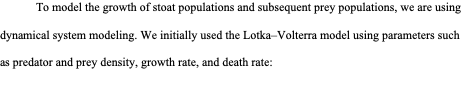

General predator-prey model

$$
\begin{align}
\frac{\partial x}{\partial t} &= ax - bxy \\
\frac{\partial y}{\partial t} &= -oy + dxy
\end{align}
$$


This model works only when predator and prey populations are initially similar. In reality, the prey population is exceptionally higher than the stoat populations. So, we will instead introduce a new model taking into account the environment's carrying capacity and rate of prey consumption. 

Modeling Stoat Growth
$$
\begin{align}
\frac{dy}{dt} = d * y * (1 - \frac{y}{K}) - h * y * x - o * y
\end{align}
$$

Modeling Prey Growth/Depletion
$$
\begin{align}
\frac{dx}{dt} = a * x * (1 - \frac{x}{Kf}) - c * x * y - b * x
\end{align}
$$

We used a logistic model including parameters of carrying capacity, rate of predation, and hunting efficiency, where Kf is prey carrying capacity, K is stoat carrying capacity, c is rate of predation, and h is hunting efficiency. This model gave us a better look at how certain constraints could have an effect on both populations.
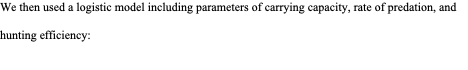
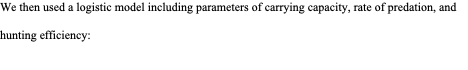
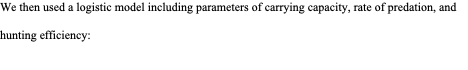
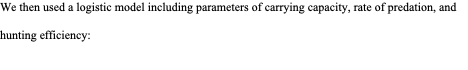
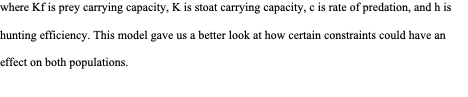
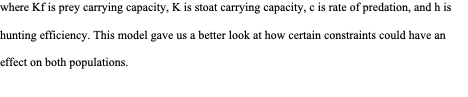
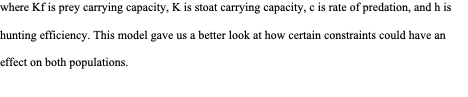
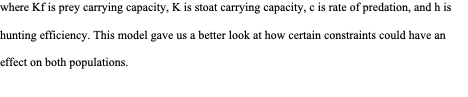

**3.2 Agent Based Modeling**

In order to account for island size, we used agent-based modeling to describe invasive stoat population growth. Modifiable parameters include the number of stoats, the radius of the island, the density of food available to the stoats, and the number of traps on the island.  

The primary driver of stoat behavior is hunger. Stoats will wander around their island until they find a neighboring piece of food, which will then become their target. 
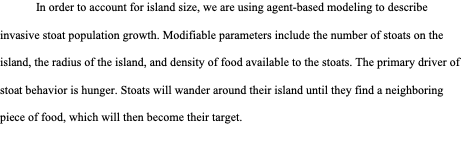
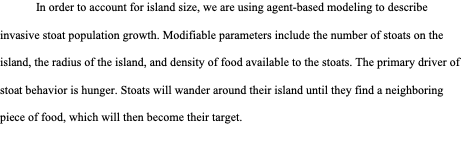
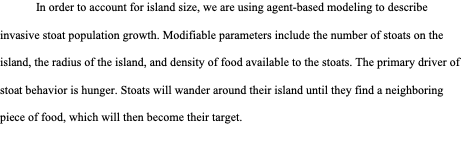
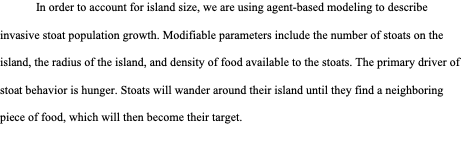

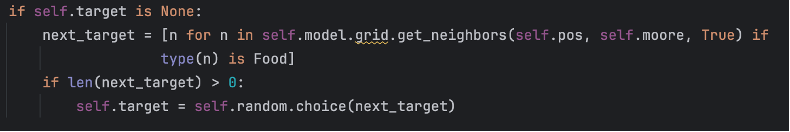

Stoats then track the target until they are able to eat it or they get too hungry and need to go home. After eating, stoats will return to their home and, if they had any leftover food, will stash it away for later.
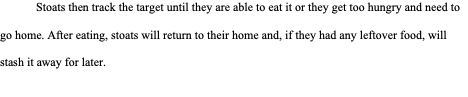
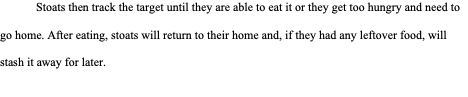
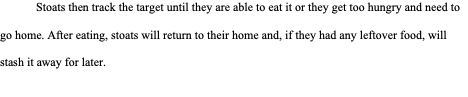
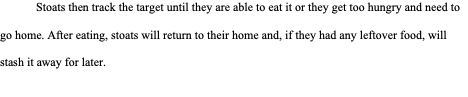

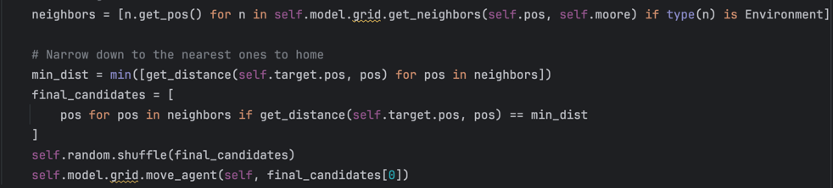

This model is limited by difficulties in modeling the passage of time and the behaviors of individual prey populations. To balance the passage of time and the number of steps required to complete a model, one step is equivalent to one hour. There are three hours per day and 36 days per year. Every 9 days, the season changes, allowing for reproduction during the Spring. Stoats die after 1000 time steps, if they are not otherwise killed by hunger or a trap.

Prey populations wonder the island randomly, as they are broadly generalized populations that likely display varying patterns of behavior. Additionally, many endemic bird populations which fall prey to stoats have no natural predators and might struggle to avoid such adept hunters. 
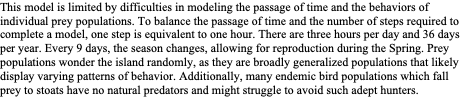
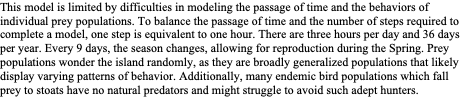
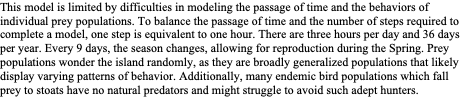
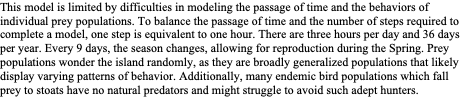

# 4. Evaluation

**3.1 Dynamical Systems**

In [267]:
from plotnine import *
from scipy.integrate import odeint
import math
import pandas as pd
import numpy as np

General predator-prey model

$$
\begin{align}
\frac{\partial x}{\partial t} &= ax - bxy \\
\frac{\partial y}{\partial t} &= -oy + dxy
\end{align}
$$


In [268]:
# Parameters

x = 10.0 # prey density
y = 10.0 # stoat density
a = 1.1 # prey growth
b = 0.4 # prey death rate
o = 0.4 # stoat death rate
d = 0.1 # stoat growth

In [269]:
# Lotka–Volterra model
sim_length = 48

def euler(func, initial, deltas):
    vals = [initial]
    for i in range(1, len(deltas)):
        cur = np.array(vals[-1][:])
        dt = deltas[i] - deltas[i - 1]
        cur += func(cur, dt)
        vals.append(cur)
    return np.array(vals)

def predprey(u, dt):
    x, y = u
    dx = (a * x - b * x * y) * dt
    dy = (-o * y  + d * x * y) * dt
    return [dx, dy]

time = np.linspace(0, sim_length, sim_length * 3000)
pop = euler(predprey, [x, y], time)

In [270]:
df = pd.DataFrame(pop, columns=["prey", "stoat"])
df["time"] = time

In [271]:
df

,prey,stoat,time
0,10.000000,10.000000,0.000000
1,9.990333,10.002000,0.000333
2,9.980673,10.003997,0.000667
3,9.971020,10.005992,0.001000
4,9.961373,10.007983,0.001333
...,...,...,...
143995,0.023019,1.950450,47.998667
143996,0.023022,1.950192,47.999000
143997,0.023024,1.949933,47.999333
143998,0.023027,1.949675,47.999667


In [272]:
dfmelt=pd.melt(df, id_vars=['time'], value_vars=["prey", "stoat"], 
               var_name='species', value_name='population')
dfmelt

,time,species,population
0,0.000000,prey,10.000000
1,0.000333,prey,9.990333
2,0.000667,prey,9.980673
3,0.001000,prey,9.971020
4,0.001333,prey,9.961373
...,...,...,...
287995,47.998667,stoat,1.950450
287996,47.999000,stoat,1.950192
287997,47.999333,stoat,1.949933
287998,47.999667,stoat,1.949675


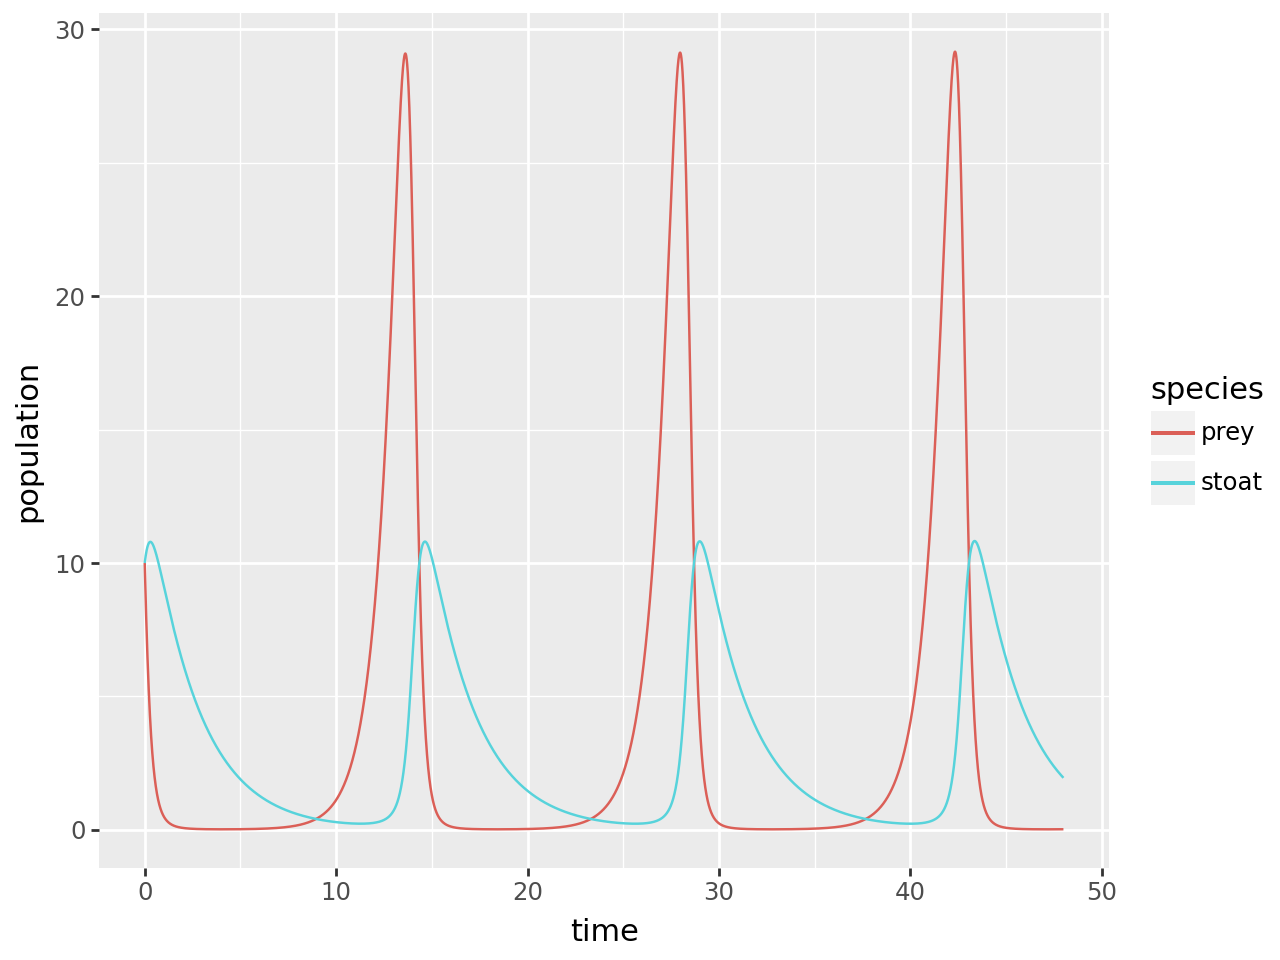

In [273]:
(
    ggplot(dfmelt, aes("time", "population", color="species"))
    + geom_line()
)

This model works only when predator and prey populations are initially similar. In reality, the prey population is exceptionally higher than the stoat populations. So, we will instead introduce a new model taking into account the environment's carrying capacity and rate of prey consumption. 

Modeling Stoat Growth
$$
\begin{align}
\frac{dy}{dt} = d * y * (1 - \frac{y}{K}) - h * y * x - o * y
\end{align}
$$

Modeling Prey Growth/Depletion
$$
\begin{align}
\frac{dx}{dt} = a * x * (1 - \frac{x}{Kf}) - c * x * y - b * x
\end{align}
$$

In [274]:
# Parameters
x = 90.0  # prey density
y = 10.0   # stoat density
a = 0.3   # prey growth rate
b = 0.01   # prey death rate
o = 0.01  # stoat death rate
d = 0.2   # stoat growth rate
K = 200   # stoat carrying capacity
Kf = 2500 # prey carrying capacity
h = 0.05 # hunting efficiency
c = 0.005 # rate of predation

sim_length = 48

def euler(func, initial, deltas):
    vals = [initial]
    for i in range(1, len(deltas)):
        cur = np.array(vals[-1][:])
        dt = deltas[i] - deltas[i - 1]
        cur += np.array(func(cur, dt)) * dt
        vals.append(cur)
    return np.array(vals)

def predprey(u, dt):
    x, y = u
    dx = a * x * (1 - (x / Kf)) - c * y * x - b * x
    dy = d * y * (1 - (y / K)) - h * y - o * y
    return [dx, dy]


time = np.linspace(0, sim_length, sim_length * 3000)

pop = euler(predprey, [x, y], time)

In [275]:
df = pd.DataFrame(pop, columns=["prey", "stoat"])
df["time"] = time

In [276]:
df

,prey,stoat,time
0,90.000000,10.000000,0.000000
1,90.006876,10.000433,0.000333
2,90.013753,10.000867,0.000667
3,90.020629,10.001300,0.001000
4,90.027507,10.001733,0.001333
...,...,...,...
143995,0.045623,137.837687,47.998667
143996,0.045617,137.837786,47.999000
143997,0.045611,137.837886,47.999333
143998,0.045605,137.837985,47.999667


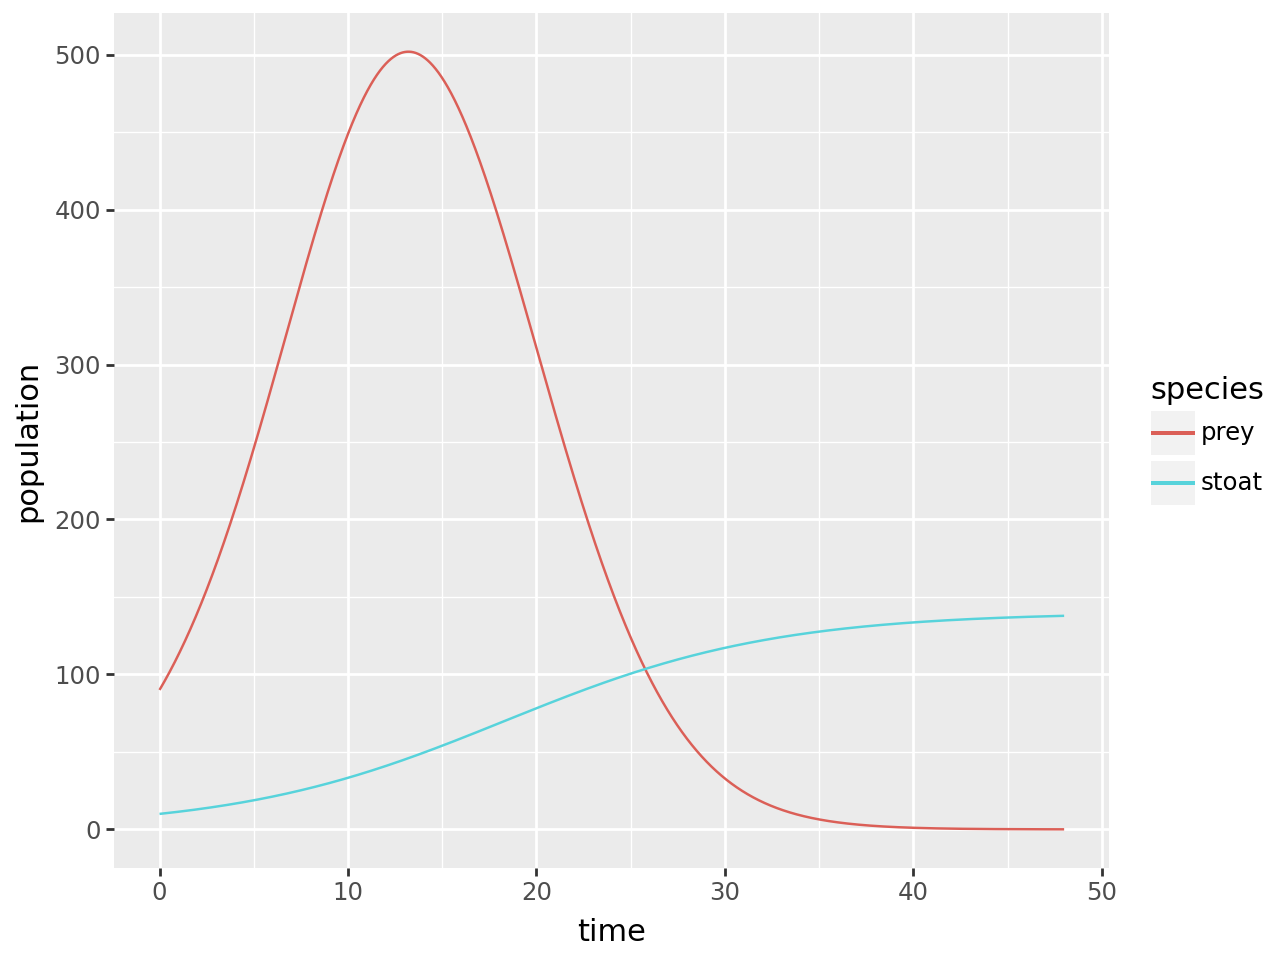

In [277]:
dfmelt=pd.melt(df, id_vars=['time'], value_vars=["prey", "stoat"], 
               var_name='species', value_name='population')
dfmelt

(
    ggplot(dfmelt, aes("time", "population", color="species"))
    + geom_line()
)

Without the presence of a predator or human-interference through trapping, the stoat populations increases until it reaches its carrying capacity or if prey populations reach 0. This model has, however, provided a useful 

In [278]:
# Parameters
x = 90.0  # prey density
y = 10.0   # stoat density
a = 0.3   # prey growth rate
b = 0.01   # prey death rate
o = 0.01  # stoat death rate
d = 0.2   # stoat growth rate
K = 200   # stoat carrying capacity
Kf = 2500 # prey carrying capacity
h = 0.05 # hunting efficiency
c = 0.005 # rate of predation

sim_length = 48

def euler(func, initial, deltas):
    vals = [initial]
    for i in range(1, len(deltas)):
        cur = np.array(vals[-1][:])
        dt = deltas[i] - deltas[i - 1]
        cur += np.array(func(cur, dt)) * dt
        vals.append(cur)
    return np.array(vals)

def predprey(u, dt):
    x, y = u
    dx = a * x * (1 - (x / Kf)) - c * y * x - b * x
    dy = d * y * (1 - (y / K)) - h * y - o * y
    return [dx, dy]


time = np.linspace(0, sim_length, sim_length * 3000)

pop = euler(predprey, [x, y], time)

In [279]:
df = pd.DataFrame(pop, columns=["prey", "stoat"])
df["time"] = time

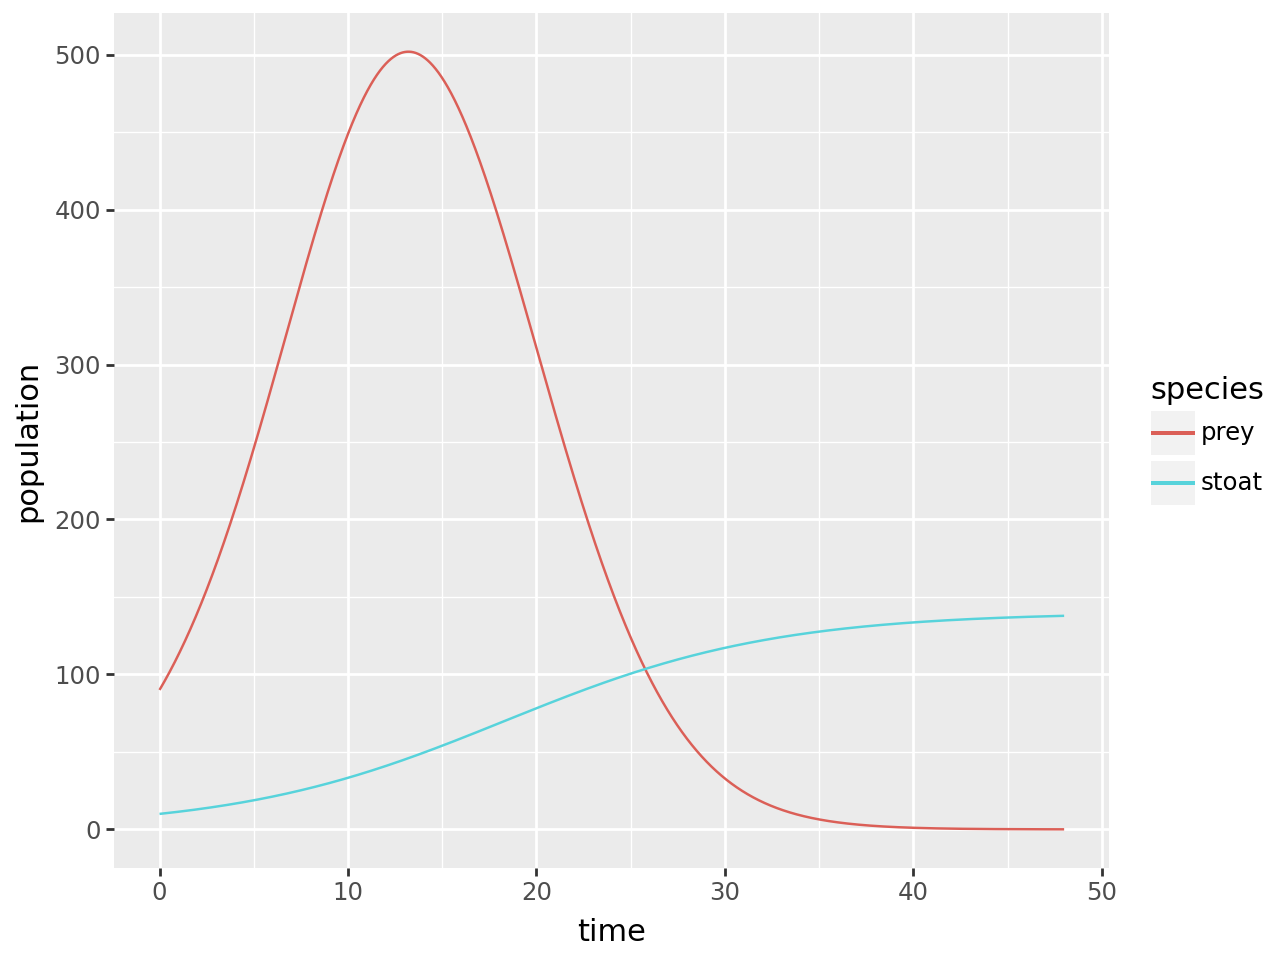

In [280]:
dfmelt=pd.melt(df, id_vars=['time'], value_vars=["prey", "stoat"], 
               var_name='species', value_name='population')
dfmelt

(
    ggplot(dfmelt, aes("time", "population", color="species"))
    + geom_line()
)

**3.2 Agent Based Modeling**

*Due to its size, the agent-based model itself is available in a supplemental notebook. Here, we will evaluate and discuss the results of the model.*

**AIM 1:**

Our first aim was to evaluate stoat population survival on variable isolated islands. We first investigated the population dynamics within our ABM. 

In [281]:
df = pd.read_csv("/kaggle/input/stoats-populations-no-traps-stoatdeath/stoatdeath_singleexample_density025_15stoats_r10_notraps.csv")
df = df.reset_index()
df['index'] = df['index'] + 1
df.head()

,index,Stoats,Food
0,1,15,249
1,2,15,218
2,3,15,218
3,4,15,15
4,5,15,6


In [282]:
dfmelt=pd.melt(df, id_vars=['index'], value_vars=["Food", "Stoats"], 
               var_name='species', value_name='population')
dfmelt = dfmelt[dfmelt['index']%50 == 0]
dfmelt.head()

,index,species,population
49,50,Food,1
99,100,Food,4
149,150,Food,8
199,200,Food,4
249,250,Food,6


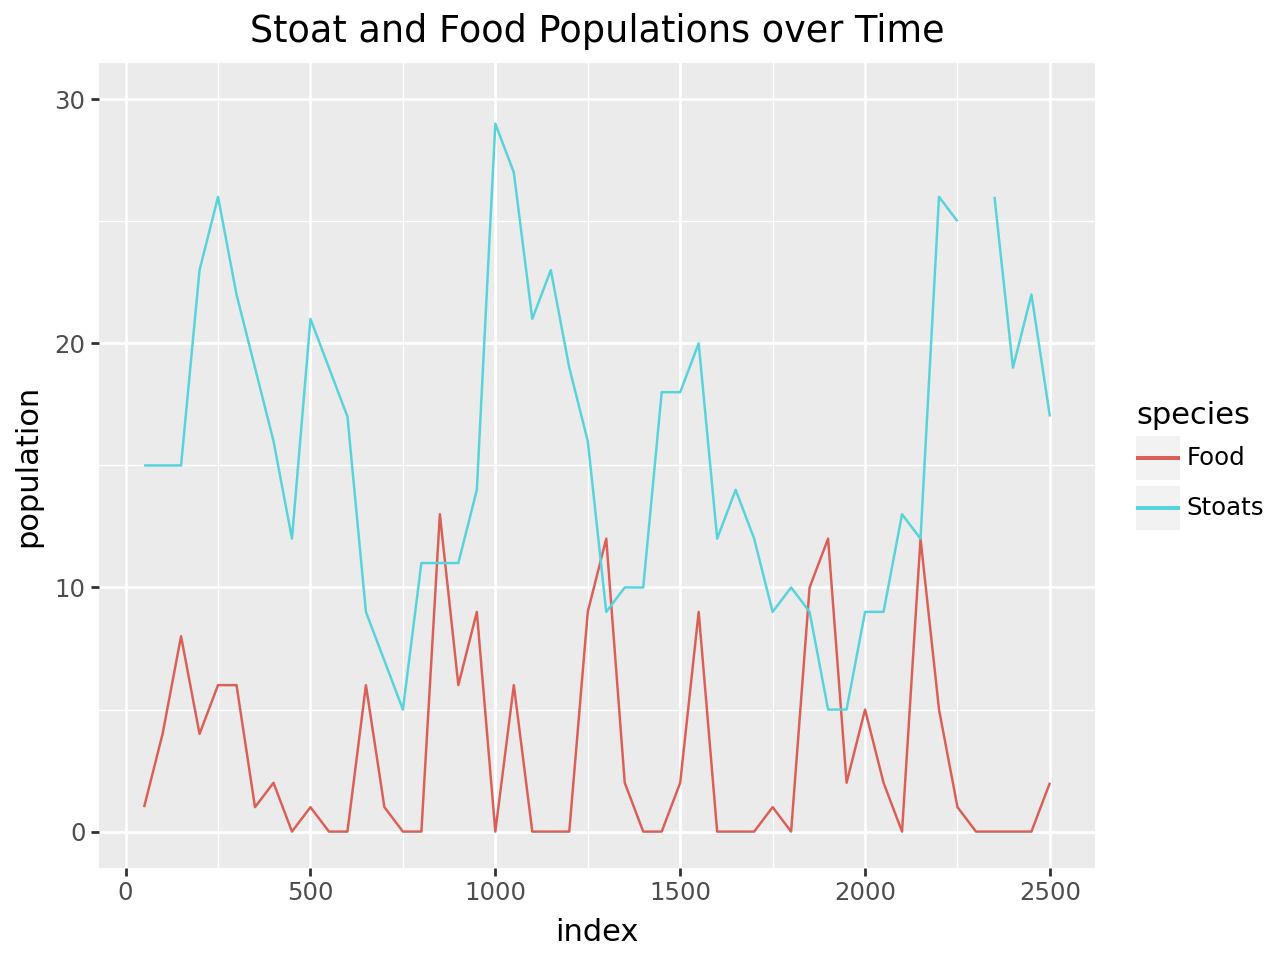

In [283]:
(
    ggplot(dfmelt, aes("index", "population", color="species"))
    + geom_line()
    + ylim(0, 30)
    + ggtitle("Stoat and Food Populations over Time")
)

As seen above, prey populations quickly dip, thus for the sake of the simulation, food is "regenerated" periodically to support the stoats. This imitates plant and prey growth in the real world. 

To evaluate this further, we ran batch simulations of the ABM which terminated upon the death of the final stoat. These simulations were run in triplicate on variable food densities (0.1, 0.25, 0.5), island sizes (radius 10, 20), and stoat numbers (5, 15, 25).

In [284]:
df = pd.read_csv("/kaggle/input/stoats-no-traps-radius-10/all.csv")
df2 = pd.read_csv("/kaggle/input/stoats-no-traps-r-20/all.csv")

df = pd.concat([df, df2], axis=0, ignore_index=True)

In [285]:
df_average = df.groupby(['stoats', 'food_density', 'radius'], as_index=False, sort=False)['Step'].mean()

df_average["stoats"] = df_average["stoats"].astype("category")
df_average["food_density"] = df_average["food_density"].astype("category")
df_average["radius"] = df_average["radius"].astype("category")


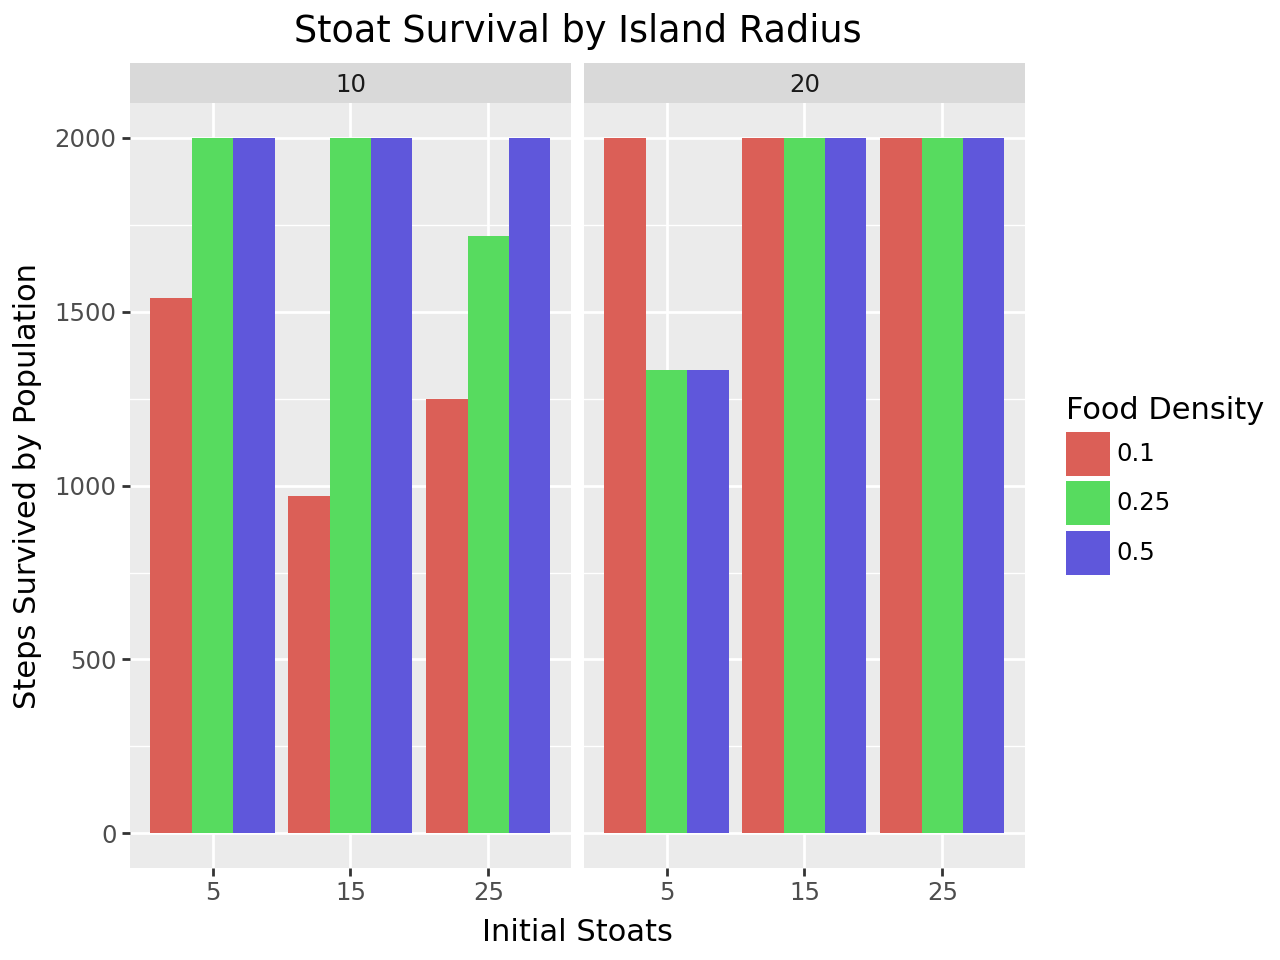

In [286]:
(
    ggplot(df_average, aes(x="stoats", y="Step", fill="food_density"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap("radius")
    + ggtitle("Stoat Survival by Island Radius")
    + xlab("Initial Stoats")
    + ylab("Steps Survived by Population")
    + labs(fill="Food Density")
)

As you can see above, food density seems to be the primary factor which determined the survivorship of the stoats. On the small island, none of the stoat groups were able to survive with a density of 0.1. Two out of three groups on the small island survived through the simulation with a density of 0.25, and all three groups survived with a plentiful food density of 0.5 on the small island. On the larger island, survivability seems to be improved overall, likely because of the increased amount of total food. The number of initial stoats does not seem to have an impact on the survivability, likely due to how quickly they reproduce. 

**AIM 2:**

Our second aim was to evaluate the efficacy of stoat trapping. To investigate, we first looked at the population dynamics within our ABM, with an equal number of traps as initial stoats. 

In [287]:
df = pd.read_csv("/kaggle/input/stoats-traps-population-equal-traps/stoatdeath_singleexample_density025_15stoats_r10_15traps.csv")
df = df.reset_index()
df['index'] = df['index'] + 1

In [288]:
dfmelt=pd.melt(df, id_vars=['index'], value_vars=["Food", "Stoats"], 
               var_name='species', value_name='population')
dfmelt = dfmelt[dfmelt['index']%50 == 0]

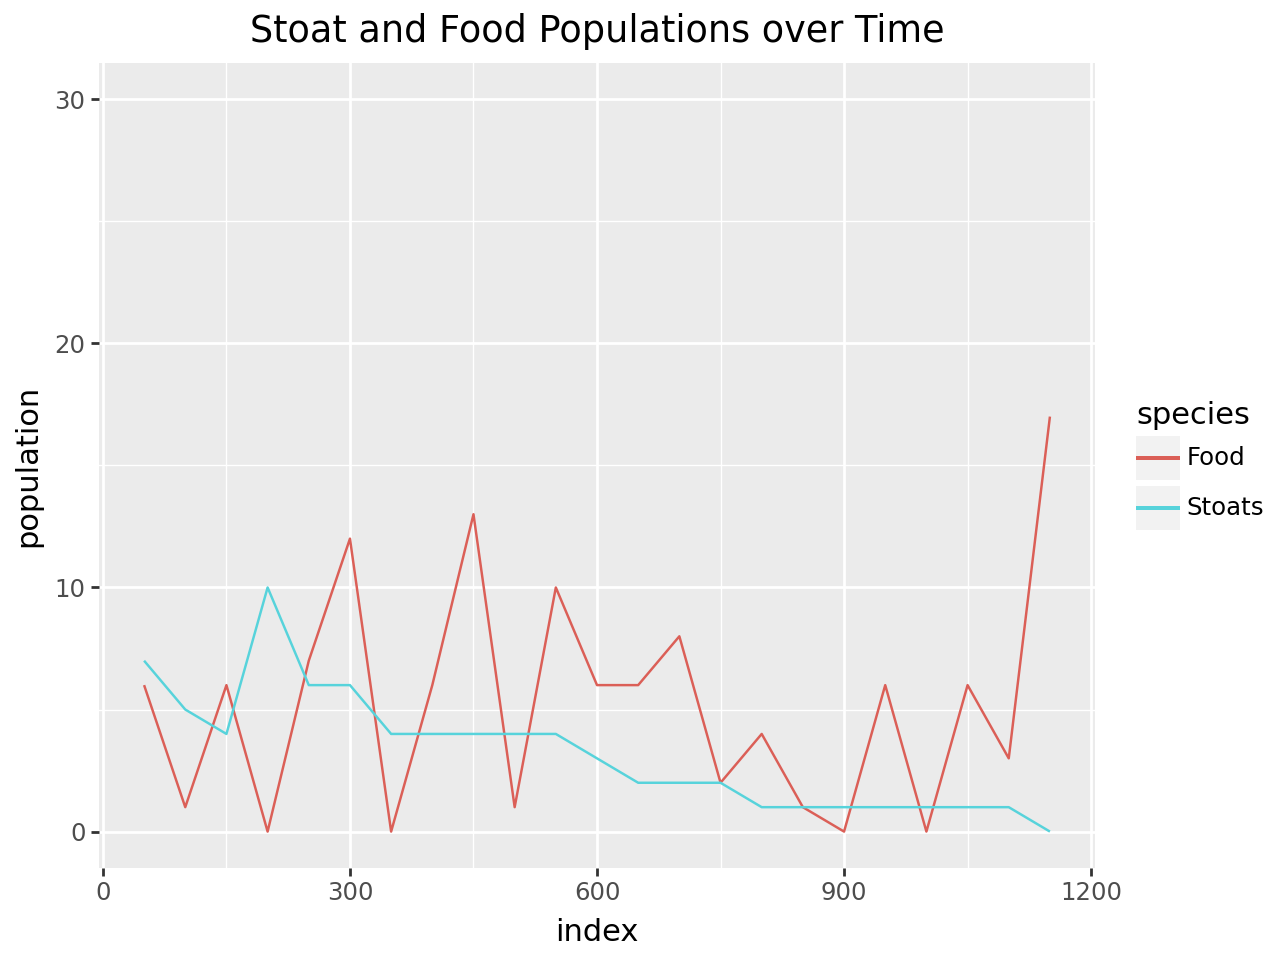

In [289]:
(
    ggplot(dfmelt, aes("index", "population", color="species"))
    + geom_line()
    + ylim(0, 30)
    + ggtitle("Stoat and Food Populations over Time")
)

As you can see, stoat populations do not show the same cyclic patterns as before, and the food populations do not crash quite as significantly as before. 

To further evaluate this, we reran the same batch experiments, introducing either the same number of traps as stoats or double the number of traps as stoats. Each trap could catch up to 3 stoats, to imitate the resetting of the trap by humans over time.

In [290]:
df = pd.read_csv("/kaggle/input/stoats-radius-10/all.csv")
#df2 = pd.read_csv("/kaggle/input/stoats-radius-20/all.csv")
#df = pd.concat([df, df2], axis=0, ignore_index=True)
df["trap status"] = df["traps"] / df["stoats"]

In [291]:
df_average = df.groupby(['stoats', 'food_density', 'trap status'], as_index=False, sort=False)['Step'].mean()
df_average["stoats"] = df_average["stoats"].astype("category")
df_average["food_density"] = df_average["food_density"].astype("category")
df_average["trap status"] = df_average["trap status"].astype("category")

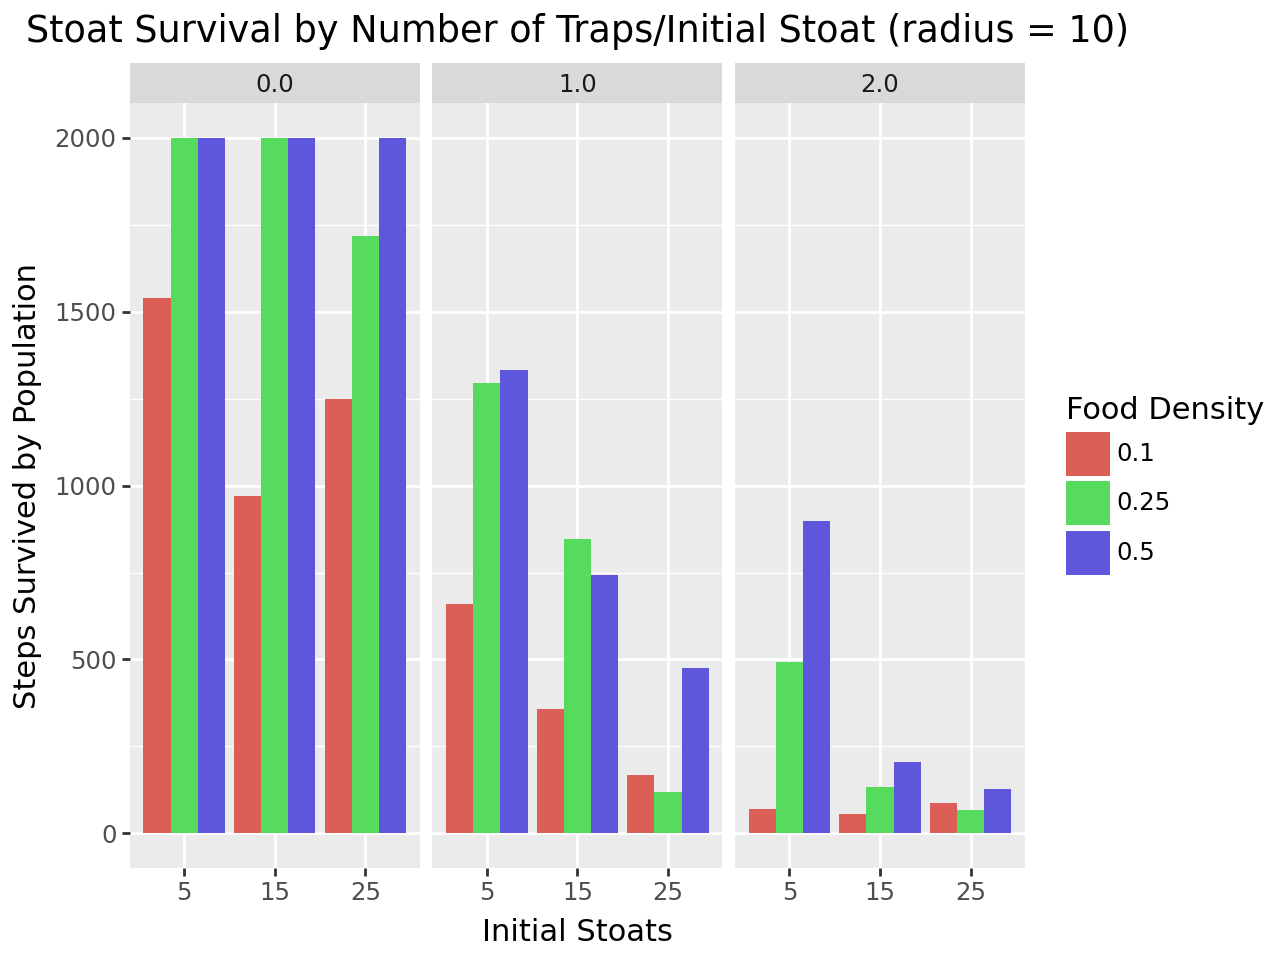

In [292]:

(
    ggplot(df_average, aes(x="stoats", y="Step", fill="food_density"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap("trap status")
    + ggtitle("Stoat Survival by Number of Traps/Initial Stoat (radius = 10)")
    + xlab("Initial Stoats")
    + ylab("Steps Survived by Population")
    + labs(fill="Food Density")
)

In [293]:
df = pd.read_csv("/kaggle/input/stoats-radius-20/all.csv")
#df = pd.concat([df, df2], axis=0, ignore_index=True)
df["trap status"] = df["traps"] / df["stoats"]

In [294]:
df_average = df.groupby(['stoats', 'food_density', 'trap status'], as_index=False, sort=False)['Step'].mean()
df_average["stoats"] = df_average["stoats"].astype("category")
df_average["food_density"] = df_average["food_density"].astype("category")
df_average["trap status"] = df_average["trap status"].astype("category")

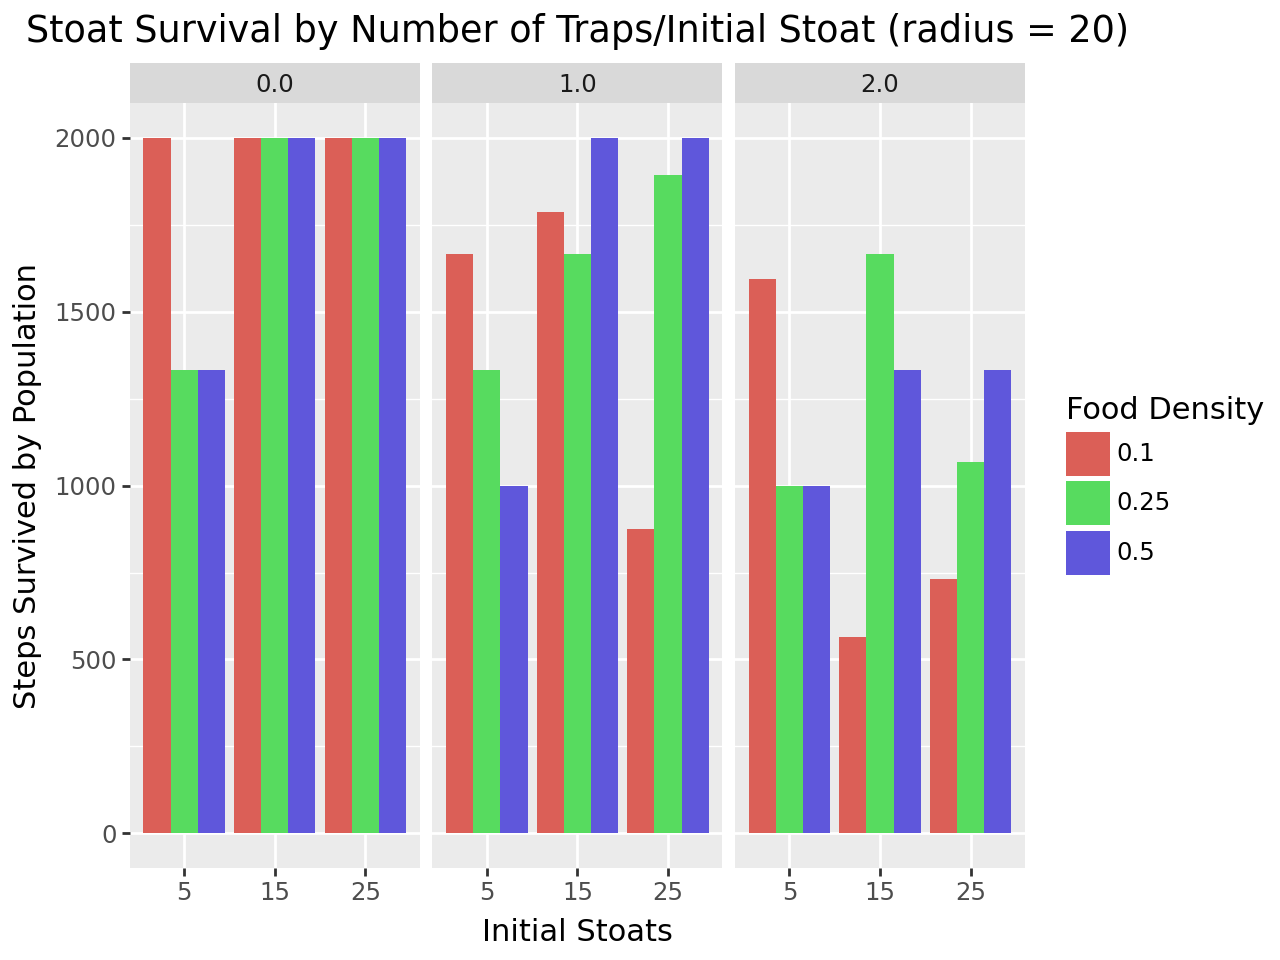

In [295]:
(
    ggplot(df_average, aes(x="stoats", y="Step", fill="food_density"))
    + geom_bar(stat="identity", position="dodge")
    + facet_wrap("trap status")
    + ggtitle("Stoat Survival by Number of Traps/Initial Stoat (radius = 20)")
    + xlab("Initial Stoats")
    + ylab("Steps Survived by Population")
    + labs(fill="Food Density")
)

As seen above, implementing an equal number of traps as stoats is *effective* at reducing stoat populations in an isolated area, particularly on smaller islands, where the stoats are more likely to be caught. Further, implenting double the number of traps as initial stoats is *extremely effective*, especially on smaller islands. On larger islands, the effect is less pronounced, but we can still observe a distinct decrease in the number of steps survived by the population. In particular, none of the stoat populations were able to survive to the end of the simulation when traps were present, regardless of food density or initial food density. 

**AIM 3:**

Our final aim was to evaluate the effects of stoat invasion on prey populations. First, we can take a look at the population dynamics of the stoats and the prey on an island of radius 10, 15 initial stoats, a food density of 0.25, and no traps. 

In [296]:
df = pd.read_csv("/kaggle/input/fooddeath/fooddeath full example/fooddeath_example_r10_15stoats_0.25density_notraps.csv")
df = df.reset_index()
df['index'] = df['index'] + 1
dfmelt=pd.melt(df, id_vars=['index'], value_vars=["Food", "Stoats"], 
               var_name='species', value_name='population')
dfmelt = dfmelt[dfmelt['index']%50 == 0]

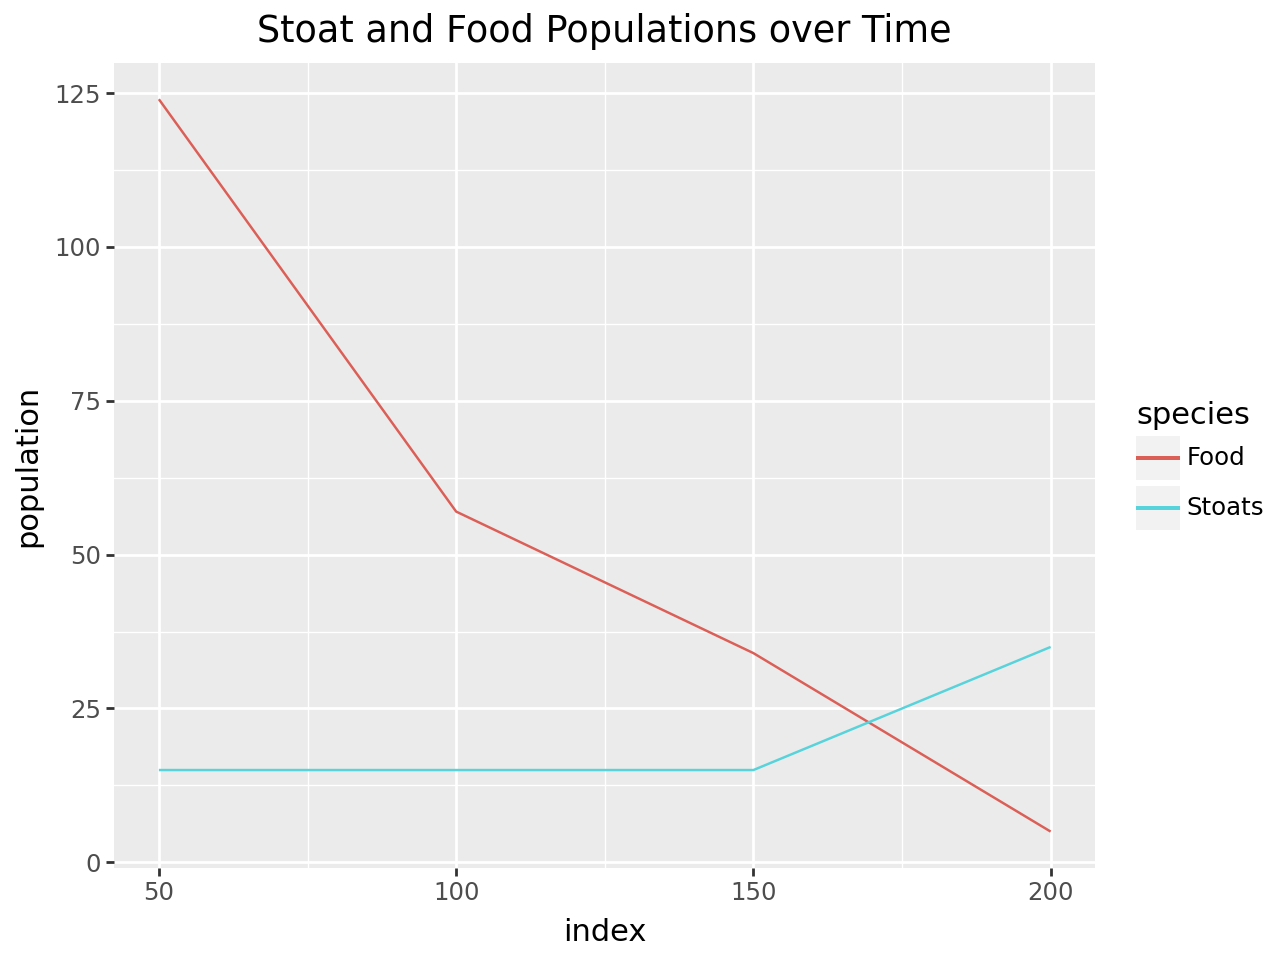

In [297]:
(
    ggplot(dfmelt, aes("index", "population", color="species"))
    + geom_line()
    + ggtitle("Stoat and Food Populations over Time")
)

We see that even before a slight increase in stoat population, the food population is devastated. 

To further evaluate this, we repeated a subset of our previous experimental conditions, but the model terminated when food density dropped under a threshold, instead of when the final stoat died. We evaluated the impacts on prey with an inital density of 0.1, 0.25, and 0.5 with 15 stoats on an island of radius 10. We simulated the impacts with zero traps and with an equal number of traps as stoats. 

In [298]:
df = pd.read_csv("/kaggle/input/stoats-steps-to-food-death/stepstofooddeath.csv")
#df = pd.concat([df, df2], axis=0, ignore_index=True)
df["trap status"] = df["traps"] / df["stoats"]

In [299]:
df_average = df.groupby(['stoats', 'food_density', 'trap status'], as_index=False, sort=False)['Step'].mean()
df_average["stoats"] = df_average["stoats"].astype("category")
df_average["food_density"] = df_average["food_density"].astype("category")
df_average["trap status"] = df_average["trap status"].astype("category")

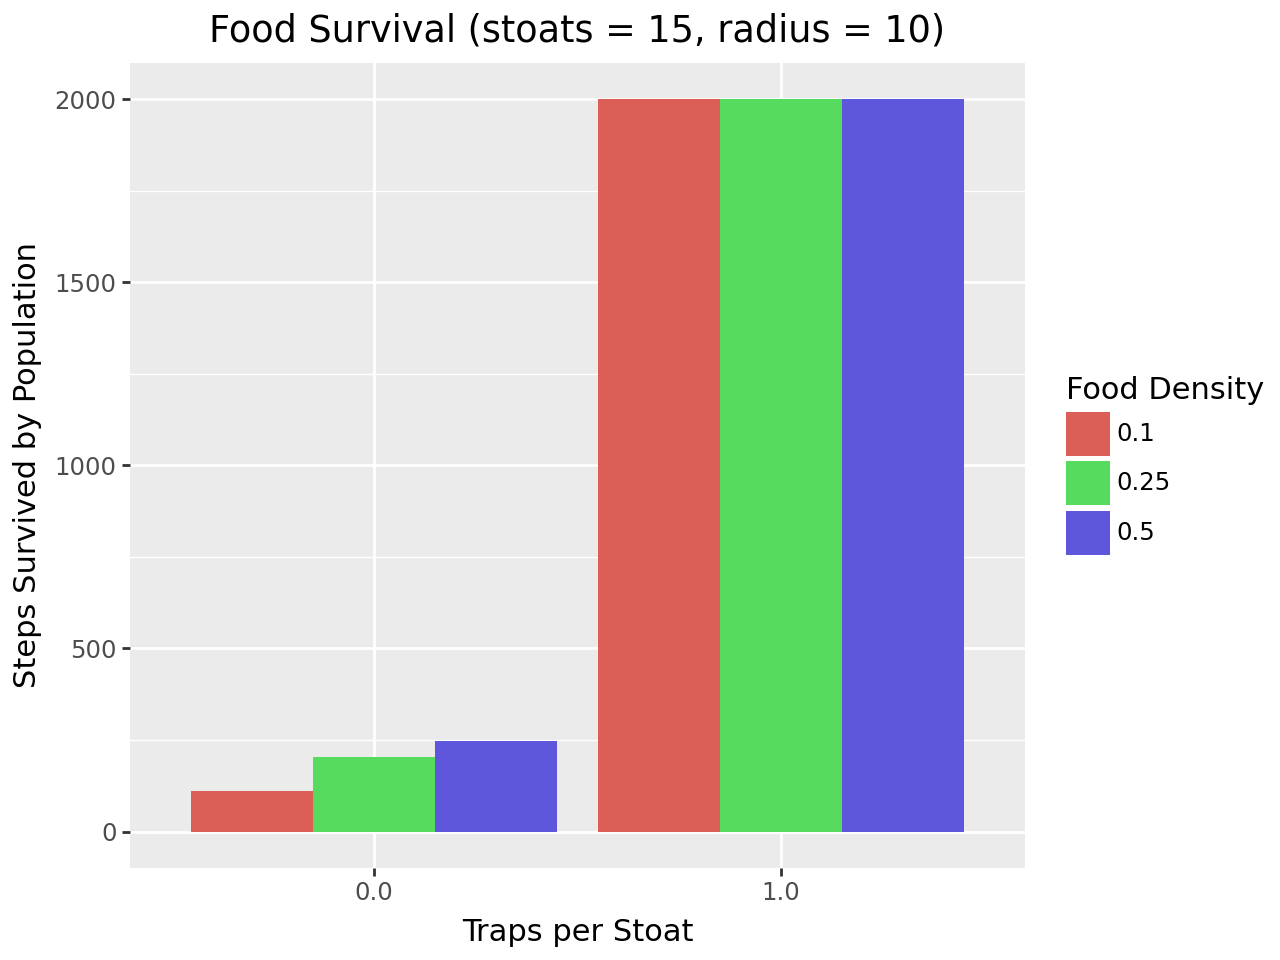

In [300]:
(
    ggplot(df_average, aes(x="trap status", y="Step", fill="food_density"))
    + geom_bar(stat="identity", position="dodge")
    + ggtitle("Food Survival (stoats = 15, radius = 10)")
    + xlab("Traps per Stoat")
    + ylab("Steps Survived by Population")
    + labs(fill="Food Density")
)

Food survival appears to be significantly improved by the introduction of traps! The food population is devastated very quickly by stoat populations in the absence of traps. The introducted on one trap per stoat allows the food to survive for the duration of the simulation!

# 5. Conclusions

Traps: While it may not be feasible to add as many traps as stoats (or double) once the population grows out of control, trapping early may effectively decrease population survivability.

# 6. Future Work

**Dynamical Systems**

**Agent Based Modeling**

# 7. References